# Trained vs Untrained Model
- out["reward"] : The completion time of all scheduling operations.
- Model : L2DPPOModel
- Policy : L2DPolicy4PPO

In [1]:
import time

from rl4co.envs.scheduling.djssp.env import DJSSPEnv
from rl4co.models import L2DPolicy, L2DModel
from rl4co.utils import RL4COTrainer
import gc
from rl4co.envs import JSSPEnv
from rl4co.models.zoo.l2d.model import L2DPPOModel
from rl4co.models.zoo.l2d.policy import L2DPolicy4PPO
from torch.utils.data import DataLoader
import json
import os
%load_ext autoreload
%autoreload 2
generator_params = {
"num_jobs" : 6 ,
"num_machines": 6 ,
"min_processing_time": 1 ,
"max_processing_time": 99 ,
"mtbf" : 17 ,
"mttr" : 4
}
env = DJSSPEnv(generator_params=generator_params,
_torchrl_mode=True,
stepwise_reward=True)


C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    accelerator = "gpu"
    batch_size = 4
    train_data_size = 2_000
    embed_dim = 128
    num_encoder_layers = 4
else:
    accelerator = "cpu"
    batch_size = 2
    train_data_size = 1_000
    embed_dim = 64
    num_encoder_layers = 2

In [3]:
# Policy: neural network, in this case with encoder-decoder architecture
policy = L2DPolicy4PPO(
    embed_dim=embed_dim,
    num_encoder_layers=num_encoder_layers,
    env_name="djsp",
    het_emb=False
)


C:\Program Files\JetBrains\PyCharm 2024.2\plugins\python-ce\helpers\pydev\pydevd_plugins\__init__.py:2: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydevd_plugins')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__('pkg_resources').declare_namespace(__name__)
C:\Program Files\JetBrains\PyCharm 2024.2\plugins\python-ce\helpers\pydev\pydevd_plugins\extensions\__init__.py:2: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydevd_plugins.extensions')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__('pkg_resources').declare_namespace(__name__)
C:\Program Files\JetBrains\PyCharm 2024.2\plugin

In [4]:
model = L2DPPOModel(
    env=env,
    policy=policy,
    batch_size=32,
    train_data_size=train_data_size,
    val_data_size=1_000,
    optimizer_kwargs={"lr": 1e-4}
)

C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


## Scheduling of the `untrained model`

In [5]:
td = env.reset(batch_size=[1])
out = model.policy.generate(td.clone(), env=env, phase="test", decode_type="multistart_sampling", num_starts=100, select_best=True)


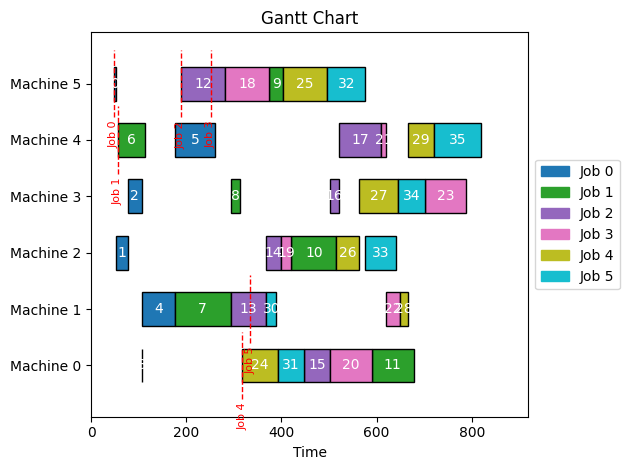

In [6]:
env.render(out["td"],0)

In [8]:
out["reward"]

tensor([-818.8461])

## Training the model
- For computational time considerations, the maximum epochs and batch sizes were kept low.

In [ ]:

trainer = RL4COTrainer(
    max_epochs=1,
    accelerator=accelerator,
    devices=1,
    logger=None,
)

trainer.fit(model)

model = model.to(device)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Overriding gradient_clip_val to None for 'automatic_optimization=False' models
C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\lightning\pytorch\utilities\parsing.py:45: Attribute 'policy' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.s

## Scheduling of the `trained model`

In [ ]:
out = model.policy.generate(td.clone(), env=env, phase="test", decode_type="multistart_sampling", num_starts=100, select_best=True)

In [ ]:
env.render(out["td"],0)

## Exact finishing time 

In [ ]:
# Finish time of the scheduling
out["reward"]